# Market Basket Analysis Project

### Business Purpose and Objectives

In this notebook we invesitage the Instacart grocery purchase dataset and apply a Market Basket Analysis 

#### The key objectives are to:
* Understand customers purchases and pattens 
* Answer questions and find inights to to improve purchasing experience
* Improve product placement and recommend potential for upsell

#### Business Questions of interest:
* Which are the most purpolar items purchased ? Which are the least ?
* What does the distrubution of the products purchased look like ?
* Do customers purchase items together frequently and which products are most often purchased together ?
* Can we use this information to recommend other products based on a customer’s cart ?

### Instacart Dataset Information

“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on 1/13/2021 <br>
If you have questions about this dataset, you can reach out to us directly at open.data@instacart.com.

## Market Basket Analysis &  Association Rules

In this section we use association rules and the a priori algorithm to identify purchase patterns and answer the following questions: 
* Do customers purchase items together frequently and which products are most often purchased together ?
* Can we use this information to recommend other products based on a customer’s cart ?

#### Load prepared dataset 

In [178]:
orders_combined_df = pd.read_pickle("data/orders_combined.pkl")
orders_combined_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


#### Analyze only the most popular items and with a  cumulative percentage purchase count below 50%

In [179]:
popular_items_filter = item_frequency_df['Cum_Percent'] < 50
popular_item_df = item_frequency_df[popular_items_filter]
popular_item_df.head()

,Product,Count,Percent,Cum_Percent,rank,description
0,Banana,18726,1.352432,1.352432,1.0,rank:1 pct:1.35 cum_pct:1.35
1,Bag of Organic Bananas,15480,1.117999,2.470430,2.0,rank:2 pct:1.12 cum_pct:2.47
2,Organic Strawberries,10894,0.786788,3.257218,3.0,rank:3 pct:0.79 cum_pct:3.26
3,Organic Baby Spinach,9784,0.706621,3.963840,4.0,rank:4 pct:0.71 cum_pct:3.96
4,Large Lemon,8135,0.587527,4.551367,5.0,rank:5 pct:0.59 cum_pct:4.55


In [180]:
# We have reduced our analysis from 40k products to 852 (the most popular ones)
orders_combined_df['product_name'].nunique(), len(popular_item_df)

(39123, 852)

In [181]:
# The 852 items have been purchased cklose to 700K times !
filter = orders_combined_df['product_name'].isin(popular_item_df['Product'])
orders_combined_filtered_df = orders_combined_df[filter]

len(orders_combined_filtered_df)

692147

#### Analyze only the user with the highest purchase count (top 2500 users)

In [182]:
filter = user_frequency_df['rank'] < 2500
bigbasket_user_frequency_df = user_frequency_df[filter]
bigbasket_user_frequency_df.head()

,User,Count,Percent,Cum_Percent,rank,description
0,149753,80,0.005778,0.005778,1.0,rank:1 pct:0.01 cum_pct:0.01
1,197541,80,0.005778,0.011556,2.0,rank:2 pct:0.01 cum_pct:0.01
2,63458,77,0.005561,0.017117,3.0,rank:3 pct:0.01 cum_pct:0.02
3,83993,76,0.005489,0.022606,4.0,rank:4 pct:0.01 cum_pct:0.02
4,189951,76,0.005489,0.028094,5.0,rank:5 pct:0.01 cum_pct:0.03


In [183]:
bigbasket_user_frequency_df.tail()

,User,Count,Percent,Cum_Percent,rank,description
2494,25440,33,0.002383,7.048231,2495.0,rank:2495 pct:0.0 cum_pct:7.05
2495,34950,33,0.002383,7.050614,2496.0,rank:2496 pct:0.0 cum_pct:7.05
2496,110956,33,0.002383,7.052997,2497.0,rank:2497 pct:0.0 cum_pct:7.05
2497,167191,33,0.002383,7.055381,2498.0,rank:2498 pct:0.0 cum_pct:7.06
2498,22273,33,0.002383,7.057764,2499.0,rank:2499 pct:0.0 cum_pct:7.06


In [184]:
# The top 2500 costumers have been purchased close to 100K items !

filter = orders_combined_df['user_id'].isin(
    bigbasket_user_frequency_df['User'])
orders_combined_filtered_df = orders_combined_df[filter]

len(orders_combined_filtered_df), orders_combined_filtered_df['product_id'].nunique()

(97723, 17085)

#### Create a binary matrix of product baskets (by orders)

In [185]:
# The matrix is very wide - 17k rows, 1 for each product previsouly filtered
basket = (orders_combined_filtered_df
          .groupby(['order_id', 'product_name'])['product_id']
          .count())
basket = basket.unstack().reset_index().fillna(0).set_index('order_id')
basket.shape

(2499, 17085)

In [128]:
basket.head()

product_name,#2 Coffee Filters,& Go! Hazelnut Spread + Pretzel Sticks,0 Calorie Acai Raspberry Water Beverage,0 Calorie Fuji Apple Pear Water Beverage,0 Calorie Strawberry Dragonfruit Water Beverage,0% Fat Black Cherry Greek Yogurt y,0% Fat Blueberry Greek Yogurt,0% Fat Free Organic Milk,0% Fat Greek Yogurt Black Cherry on the Bottom,0% Fat Organic Greek Vanilla Yogurt,...,of Hanover 100 Calorie Pretzels Mini,smart Blend Chicken & Rice Formula Dry Dog Food,smartwater® Electrolyte Enhanced Water,vitaminwater® XXX Acai Blueberry Pomegranate,with Bleach Disinfectant Cleanser Scratch Free Lavender Fresh,with Crispy Almonds Cereal,with Olive Oil Mayonnaise,with Olive Oil Mayonnaise Dressing,with Sweet & Smoky BBQ Sauce Cheeseburger Sliders,with a Splash of Mango Coconut Water
order_id,,,,,,,,,,,,,,,,,,,,,
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
# Now encode the matrix with 0 & 1 only in case the same product was purchased multiple times in an order
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1


basket_sets = basket.applymap(encode_units)

#### Apply the A Priori Algorithm to the matrix

* With the mlxtend library, association rules look like this: {Item A} -> {Item B} and can be interpreted as the existence of a strong relationship between these items and that customers that purchased Item A often also purchased Item B in the same transaction.

* {Item A} is the called the antecedent and the {Item B} is called the consequent. Both antecedents and consequents can have multiple items.

Key definitions:
>
> * **Support**: Support is an indication of how frequently the itemset appears in the dataset.
> * **Confidence**: Confidence is an indication of how often the rule has been found to be true.
> * **Lift**: lift the ratio of the observed support to that expected if X and Y were independent. If the lift is > 1, that lets us know the degree to which those two occurrences are dependent on one another (strength of the relationship).
>
Source: https://en.wikipedia.org/wiki/Association_rule_learning

In [137]:
# Import association rules libaries
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [141]:
#frequent_itemsets = apriori(
#    basket_sets, min_support=0.02, use_colnames=True, max_len=3)
#frequent_itemsets

In [142]:
rules = association_rules(
    frequent_itemsets, metric="confidence", min_threshold=0.1)

In [144]:
# The a priori algorithm has identified ~800 rules from the dataset
rules.shape

(808, 9)

In [145]:
# Let's identify the items purchased with the highest lift 
rules.sort_values('lift', ascending=False)[:15]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
660,(Organic Yellow Onion),"(Organic Garlic, Bag of Organic Bananas)",0.119248,0.057223,0.025210,0.211409,3.694490,0.018386,1.195522
657,"(Organic Garlic, Bag of Organic Bananas)",(Organic Yellow Onion),0.057223,0.119248,0.025210,0.440559,3.694490,0.018386,1.574345
659,(Organic Garlic),"(Organic Yellow Onion, Bag of Organic Bananas)",0.122049,0.057623,0.025210,0.206557,3.584631,0.018177,1.187706
658,"(Organic Yellow Onion, Bag of Organic Bananas)",(Organic Garlic),0.057623,0.122049,0.025210,0.437500,3.584631,0.018177,1.560802
797,"(Organic Hass Avocado, Organic Strawberries)",(Organic Lemon),0.075630,0.092437,0.021208,0.280423,3.033670,0.014217,1.261246
801,(Organic Lemon),"(Organic Hass Avocado, Organic Strawberries)",0.092437,0.075630,0.021208,0.229437,3.033670,0.014217,1.199603
740,"(Organic Avocado, Limes)",(Large Lemon),0.042417,0.178071,0.022009,0.518868,2.913822,0.014456,1.708323
741,(Large Lemon),"(Organic Avocado, Limes)",0.178071,0.042417,0.022009,0.123596,2.913822,0.014456,1.092627
664,(Organic Hass Avocado),"(Organic Lemon, Bag of Organic Bananas)",0.184474,0.050820,0.027211,0.147505,2.902489,0.017836,1.113414
663,"(Organic Lemon, Bag of Organic Bananas)",(Organic Hass Avocado),0.050820,0.184474,0.027211,0.535433,2.902489,0.017836,1.755455


In [148]:
# We can also identify recomemndations in baskets with more than 1 items purchased
rules['items number'] = rules['antecedents'].apply(lambda x: len(x))
rules['description'] = rules['antecedents'].astype(
    "unicode") + "=>" + rules['consequents'].astype("unicode")
rules_sorted = rules[rules['items number'] > 1].sort_values('lift', ascending=False).head()
rules_sorted

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,items number,description
657,"(Organic Garlic, Bag of Organic Bananas)",(Organic Yellow Onion),0.057223,0.119248,0.025210,0.440559,3.694490,0.018386,1.574345,2,"frozenset({'Organic Garlic', 'Bag of Organic B..."
658,"(Organic Yellow Onion, Bag of Organic Bananas)",(Organic Garlic),0.057623,0.122049,0.025210,0.437500,3.584631,0.018177,1.560802,2,"frozenset({'Organic Yellow Onion', 'Bag of Org..."
797,"(Organic Hass Avocado, Organic Strawberries)",(Organic Lemon),0.075630,0.092437,0.021208,0.280423,3.033670,0.014217,1.261246,2,"frozenset({'Organic Hass Avocado', 'Organic St..."
740,"(Organic Avocado, Limes)",(Large Lemon),0.042417,0.178071,0.022009,0.518868,2.913822,0.014456,1.708323,2,"frozenset({'Organic Avocado', 'Limes'})=>froze..."
663,"(Organic Lemon, Bag of Organic Bananas)",(Organic Hass Avocado),0.050820,0.184474,0.027211,0.535433,2.902489,0.017836,1.755455,2,"frozenset({'Organic Lemon', 'Bag of Organic Ba..."


**We now have a way to recommend customers addtional product based on the patterns in the Instacart dataset !**

In [159]:
rules_sorted['description'].iloc[0], rules_sorted['description'].iloc[3]

("frozenset({'Organic Garlic', 'Bag of Organic Bananas'})=>frozenset({'Organic Yellow Onion'})",
 "frozenset({'Organic Avocado', 'Limes'})=>frozenset({'Large Lemon'})")

#### Visualize the Market Basket Analysis and products purchased together and their lift (strength of their relationships)

* As previously identified, Organic Garlic, Bag of Organic Bananas and Organic Yellow Onion have strong relationships
* Other examples include Organic Hass Avocado, Organic Strawberrie and Organic Lemon 

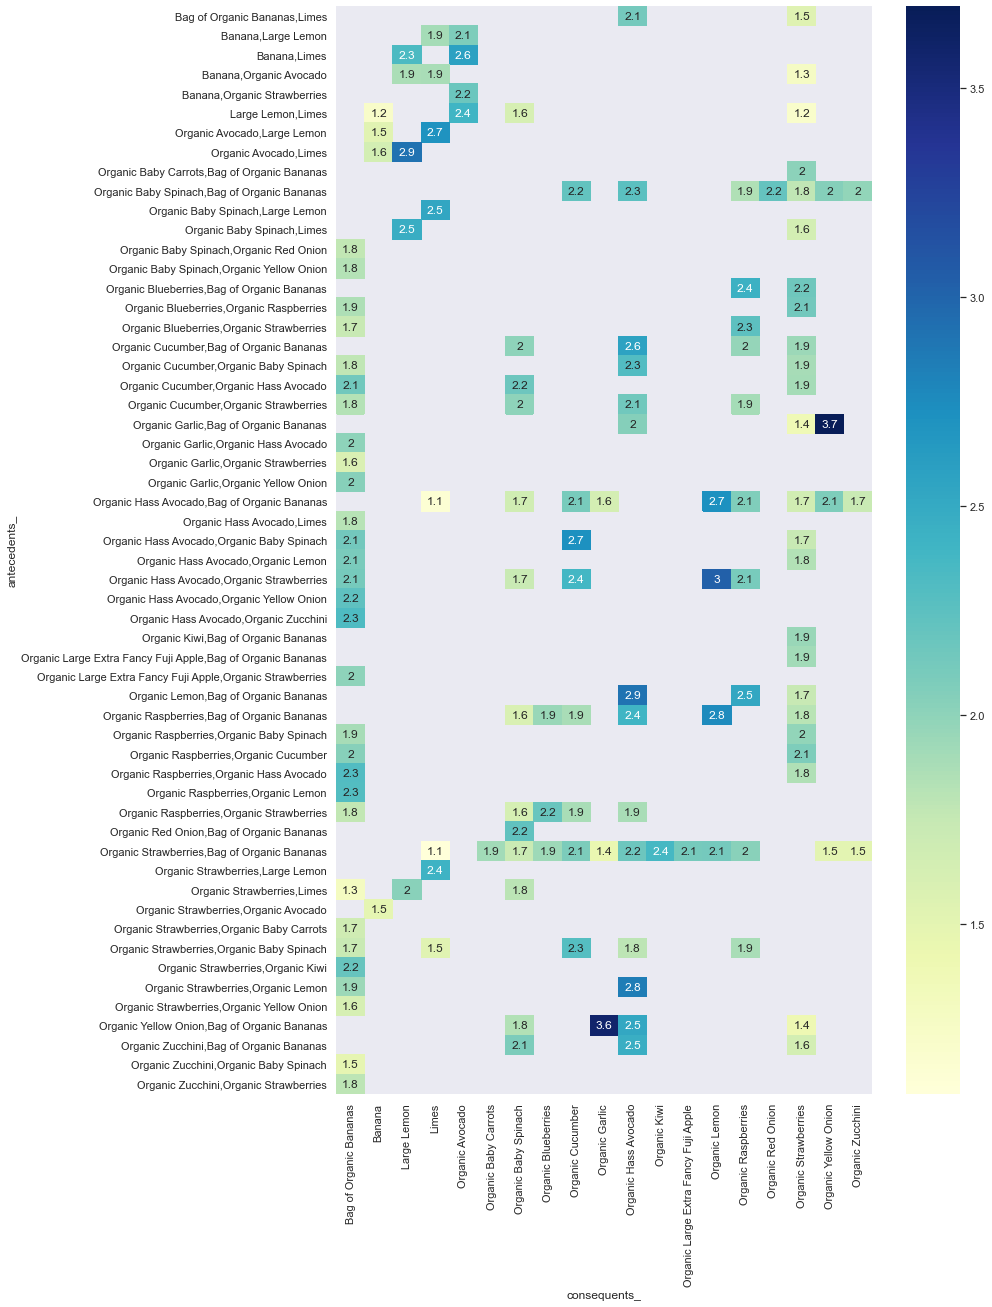

In [161]:
# Heatmap showing the the items lift 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize': (12, 20)})

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))


# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['items number'] > 1].pivot(index='antecedents_',
                                               columns='consequents_', values='lift')

# Generate a heatmap with annotations on and the colorbar off
sns.heatmap(pivot, annot=True, cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [162]:
# Scatter plot showing support, confidence and lift of popular purchased items
fig = px.scatter(rules, x="support", y="confidence", hover_name="description", hover_data=["lift"], color="lift",
                 color_continuous_scale='bluyl', title="Scatter Plot")
fig.show()

## Conclusion
* Using association rules we have identfied items that customers purchase together frequently and which products are most often purchased together
* In addition, we have an apriori model that we can use to recommend instcart customer products based their existing cart !